# Fixed Figure Solution

This code implements fixes for the y-axis label alignment issues and consistent scaling between panels.


In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import seaborn as sns
from scipy.optimize import curve_fit
from matplotlib.lines import Line2D


# Define linear fit function
def linear_fit(x, a, b):
    return a * x + b


# Load and prepare data (reusing from your existing cells)
dataset_path = Path().cwd() / "Model vs Exp for hdh.h5xp"
dt = xr.open_datatree(dataset_path, engine="h5netcdf", phony_dims="sort")[
    "/Packed Data"
].to_dataset()

# Get energy and experimental data
energy = dt["expEnergy1_alpha27"].to_numpy()
incident_angles = [40, 55, 70, 90]
exp_cols = {f"spec_{i}": dt[f"expSpec{i}_alpha27"].to_numpy() for i in range(1, 5)}
exp_cols["energy"] = energy
df = pd.DataFrame(exp_cols)
df = df.rename(
    columns={
        f"spec_{i}": f"{angle}" for i, angle in enumerate(incident_angles, start=1)
    }
)

# Get fitted data
fitted_cols = {
    f"{incident_angles[i - 1]}": dt[f"fitresults{i}_alpha27"].to_numpy()
    for i in range(1, 5)
}
fitted_cols["energy"] = energy
df_fitted = pd.DataFrame(fitted_cols)

# Calculate residuals and find the cos² fit for each energy
residuals = pd.DataFrame(
    {
        "energy": df["energy"],
        **{f"{angle}": [0] * len(df) for angle in incident_angles},
    }
)

# Get peak energies
max_90 = df.loc[df["90"].idxmax(), "energy"]
max_40 = df.loc[df["40"].idxmax(), "energy"]

# Calculate optimal parameters for linear fit
optimal = []
for i, e in enumerate(energy):
    row = df.where(df["energy"] == e).dropna()
    x = incident_angles
    cos_x = np.cos(np.radians(x)) ** 2
    y = row[[f"{angle}" for angle in incident_angles]].values.flatten()

    popt, pcov = curve_fit(
        linear_fit, cos_x, y, p0=[1, 0], bounds=([-np.inf, -np.inf], [np.inf, np.inf])
    )

    # Calculate residuals
    resid_abs = y - linear_fit(cos_x, *popt)
    resid_percentage = [(r / y_i) * 100 for r, y_i in zip(resid_abs, y) if y_i != 0]

    residuals.loc[
        residuals["energy"] == e, [f"{angle}" for angle in incident_angles]
    ] = resid_percentage

    optimal.append((e, *popt))

# Calculate clustered residuals
redisduals_clustered = pd.DataFrame(
    {
        "energy": df["energy"],
        **{f"{angle}": [0] * len(df) for angle in incident_angles},
    }
)

for i, e in enumerate(energy):
    refined_row = df_fitted.where(df_fitted["energy"] == e).dropna()
    real_row = df.where(df["energy"] == e).dropna()
    for angle in incident_angles:
        y_fit = refined_row[f"{angle}"].values.flatten()[0]
        y_real = real_row[f"{angle}"].values.flatten()[0]
        if y_real != 0:
            resid_abs = y_fit - y_real
            resid_percentage = (resid_abs / y_real) * 100
            redisduals_clustered.loc[
                redisduals_clustered["energy"] == e, f"{angle}"
            ] = resid_percentage

# Find extreme slope energies
optimal_df = pd.DataFrame(optimal, columns=["energy", "slope", "intercept"])
optimal_df = optimal_df[(optimal_df["energy"] >= 284.2) & (optimal_df["energy"] <= 300)]

# Use these target values from your code
target_max_positive = 285.61
target_max_negative = 298.437

# Find closest energies in the dataset
energy_array = optimal_df["energy"].values
closest_positive_idx = np.argmin(np.abs(energy_array - target_max_positive))
closest_negative_idx = np.argmin(np.abs(energy_array - target_max_negative))

max_positive_slope_energy = energy_array[closest_positive_idx]
max_negative_slope_energy = energy_array[closest_negative_idx]

/tmp/ipykernel_672693/862749554.py:70: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.10064975006609762' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  residuals.loc[
/tmp/ipykernel_672693/862749554.py:70: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.182362151882972' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  residuals.loc[
/tmp/ipykernel_672693/862749554.py:70: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-9.37955339342731' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  residuals.loc[
/tmp/ipykernel_672693/862749554.py:70: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an 

Y-label positions:
Residuals y-label position: (0, 0.5)
Data y-label position: (0, 0.5)


/tmp/ipykernel_672693/1312766834.py:302: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


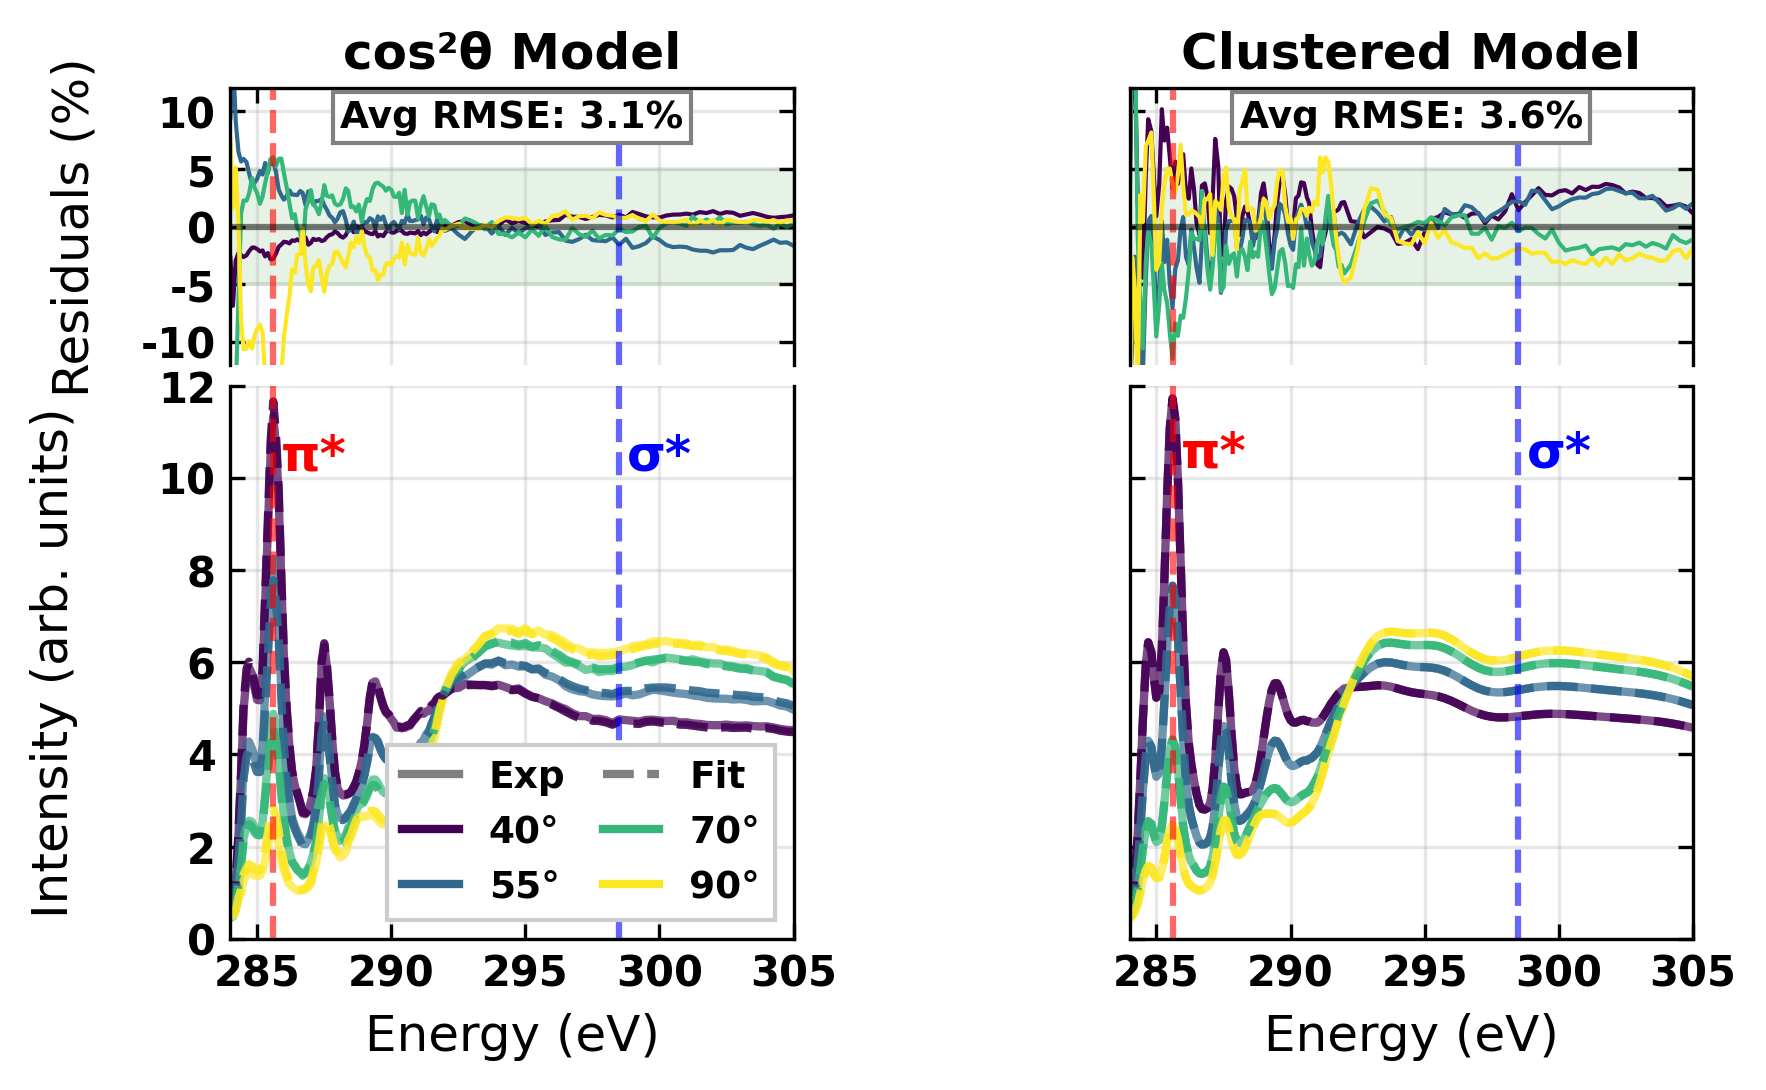

In [2]:
# Create the improved figure with fixed alignment and consistent scaling
def create_improved_figure():
    # Set plot style
    plt.rcParams["xtick.direction"] = "in"
    plt.rcParams["ytick.direction"] = "in"
    plt.rcParams["font.weight"] = "bold"

    # Create figure with mosaic layout
    fig = plt.figure(figsize=(6.5, 3.5), dpi=300, constrained_layout=False)

    # Create grid with more spacing between panels
    gs = fig.add_gridspec(
        2,
        3,
        height_ratios=[1.5, 3],
        width_ratios=[2, 0.1, 2],
        hspace=0.05,
        wspace=0.4,  # Increased for better spacing between panels
    )

    # Create the axes
    ax_residuals = fig.add_subplot(gs[0, 0])
    ax_data = fig.add_subplot(gs[1, 0], sharex=ax_residuals)
    ax_residuals_hdf = fig.add_subplot(gs[0, 2], sharex=ax_residuals)
    ax_data_hdf = fig.add_subplot(gs[1, 2], sharex=ax_residuals_hdf)

    # Filter data to energy range 284-305 eV
    energy_mask = (df["energy"] >= 284) & (df["energy"] <= 305)
    df_filtered = df[energy_mask].copy()
    df_fitted_filtered = df_fitted[energy_mask].copy()
    energy_filtered = df_filtered["energy"].to_numpy()
    residuals_filtered = residuals[energy_mask].copy()
    residuals_clustered_filtered = redisduals_clustered[energy_mask].copy()

    # Calculate RMSE values
    rmse_cos_fit = {}
    rmse_hdf_fit = {}
    for angle in incident_angles:
        rmse_cos_fit[angle] = np.sqrt(np.mean(residuals_filtered[f"{angle}"] ** 2))
        rmse_hdf_fit[angle] = np.sqrt(
            np.mean(residuals_clustered_filtered[f"{angle}"] ** 2)
        )

    avg_rmse_cos = np.mean(list(rmse_cos_fit.values()))
    avg_rmse_hdf = np.mean(list(rmse_hdf_fit.values()))

    # Colors for different angles
    colors = plt.cm.viridis(np.linspace(0, 1, len(incident_angles)))

    # Setup residual panels
    for ax, residuals_data, title, avg_rmse in [
        (ax_residuals, residuals_filtered, "cos²θ Model", avg_rmse_cos),
        (
            ax_residuals_hdf,
            residuals_clustered_filtered,
            "Clustered Model",
            avg_rmse_hdf,
        ),
    ]:
        # Add shading for good fit region
        ax.axhspan(-5, 5, color="green", alpha=0.1, zorder=0)

        # Plot residuals for each angle
        for i, angle in enumerate(incident_angles):
            ax.plot(
                residuals_data["energy"],
                residuals_data[f"{angle}"],
                color=colors[i],
                linewidth=1,
                markersize=2,
            )

        # Highlight key energies
        ax.axvline(
            x=max_positive_slope_energy,
            color="red",
            linestyle="--",
            linewidth=1.5,
            alpha=0.6,
        )
        ax.axvline(
            x=max_negative_slope_energy,
            color="blue",
            linestyle="--",
            linewidth=1.5,
            alpha=0.6,
        )

        # Configure axis appearance
        ax.tick_params(
            axis="both",
            which="both",
            bottom=False,
            top=True,
            labelbottom=False,
            right=True,
        )
        ax.spines["bottom"].set_visible(False)

        # Add title and RMSE info
        ax.set_title(title, fontweight="bold", pad=5)
        ax.text(
            294.5,
            9.5,
            f"Avg RMSE: {avg_rmse:.1f}%",
            fontsize=9,
            ha="center",
            va="center",
            bbox=dict(
                facecolor="white",
                alpha=1.0,
                boxstyle="square,pad=0.2",
                edgecolor="gray",
            ),
        )

        # Common settings
        ax.set_ylim(-12, 12)
        ax.grid(True, alpha=0.3)
        ax.axhline(y=0, color="black", linestyle="-", alpha=0.5)

    # FIX: Use same y-label for both residual panels - now on same side for alignment
    ax_residuals.set_ylabel("Residuals (%)", fontsize=12, labelpad=10)
    ax_residuals_hdf.set_ylabel("")  # No label on right panel

    # Set up y-ticks for residuals panels
    residual_ticks = np.linspace(-10, 10, 5)
    ax_residuals.set_yticks(residual_ticks)
    ax_residuals.set_yticklabels([f"{int(tick)}" for tick in residual_ticks])

    ax_residuals_hdf.set_yticks(residual_ticks)
    ax_residuals_hdf.set_yticklabels([])  # No labels on right panel

    # Define function to plot data with consistent scaling
    def plot_data(ax, df_data, is_cos_fit=True):
        # IMPORTANT FIX: Consistent scaling factor of 1e-4 across all plots
        SCALING_FACTOR = 1e-4

        # Plot experimental data for each angle
        for i, angle in enumerate(incident_angles):
            ax.plot(
                df_data["energy"],
                df_data[f"{angle}"] * SCALING_FACTOR,
                color=colors[i],
                linewidth=2,
                linestyle="-",
                alpha=0.7,
                label=f"Exp {angle}°",
            )

        # Create and plot fitted data
        if is_cos_fit:
            # Plot cos² fitted data
            for i, angle in enumerate(incident_angles):
                cos_angle = np.cos(np.radians(angle)) ** 2
                fitted_intensities = []

                for e in energy_filtered:
                    opt_params = next(
                        (params for params in optimal if params[0] == e), None
                    )
                    if opt_params:
                        a, b = opt_params[1], opt_params[2]
                        fitted_intensities.append(
                            linear_fit(cos_angle, a, b) * SCALING_FACTOR
                        )
                    else:
                        fitted_intensities.append(np.nan)

                # Plot fitted data with dashed lines
                ax.plot(
                    energy_filtered,
                    fitted_intensities,
                    color=colors[i],
                    linewidth=2,
                    linestyle="--",
                    alpha=0.9,
                    label=f"Fit {angle}°",
                )
        else:
            # For HDF5 data, the fit is already in df_fitted
            for i, angle in enumerate(incident_angles):
                ax.plot(
                    df_data["energy"],
                    df_data[f"{angle}"] * SCALING_FACTOR,
                    color=colors[i],
                    linewidth=2,
                    linestyle="--",
                    alpha=0.9,
                    label=f"Fit {angle}°",
                )

        # Highlight the π* and σ* energies
        ax.axvline(
            x=max_positive_slope_energy,
            color="red",
            linestyle="--",
            linewidth=1.5,
            alpha=0.6,
        )
        ax.axvline(
            x=max_negative_slope_energy,
            color="blue",
            linestyle="--",
            linewidth=1.5,
            alpha=0.6,
        )

        # Add π* and σ* labels
        ymax = ax.get_ylim()[1]
        ax.text(
            max_positive_slope_energy + 0.3,
            ymax * 0.9,
            "π*",
            color="red",
            fontweight="bold",
            fontsize=12,
            verticalalignment="top",
        )
        ax.text(
            max_negative_slope_energy + 0.3,
            ymax * 0.9,
            "σ*",
            color="blue",
            fontsize=12,
            fontweight="bold",
            verticalalignment="top",
        )

        # Configure spine visibility
        ax.spines["top"].set_visible(False)
        ax.grid(True, alpha=0.3)
        ax.set_xlim(284, 305)

    # Plot data in both panels
    plot_data(ax_data, df_filtered, is_cos_fit=True)
    plot_data(ax_data_hdf, df_fitted_filtered, is_cos_fit=False)

    # FIX: Set consistent intensity range for both data panels
    ax_data.set_ylim(0, 12)
    ax_data_hdf.set_ylim(0, 12)

    # FIX: Use explicit y-label with increased labelpad for better alignment
    ax_data.set_ylabel("Intensity (arb. units)", fontsize=12, labelpad=15)
    ax_data_hdf.set_ylabel("")  # No label on right panel

    # Set x-axis labels
    ax_data.set_xlabel("Energy (eV)", fontsize=12)
    ax_data_hdf.set_xlabel("Energy (eV)", fontsize=12)

    # Set consistent energy ticks
    energy_ticks = np.arange(285, 306, 5)
    for ax in [ax_data, ax_data_hdf]:
        ax.set_xticks(energy_ticks)
        ax.set_xticklabels([f"{int(e)}" for e in energy_ticks])
        ax.tick_params(axis="x", which="both", bottom=True, labelbottom=True)

    # FIX: Set explicit y-ticks with consistent formatting for intensity panels
    intensity_ticks = np.linspace(0, 12, 7)  # 0, 2, 4, 6, 8, 10, 12

    # Apply consistent tick formatting to both panels
    ax_data.set_yticks(intensity_ticks)
    ax_data.set_yticklabels([f"{int(tick)}" for tick in intensity_ticks])
    ax_data.tick_params(axis="y", which="both", left=True, labelleft=True)

    ax_data_hdf.set_yticks(intensity_ticks)
    ax_data_hdf.set_yticklabels([])  # No labels on right panel
    ax_data_hdf.tick_params(axis="y", which="both", right=True, labelright=False)

    # Create consistent legend
    legend_elements = []
    for i, angle in enumerate(incident_angles):
        if i == 0:
            legend_elements.append(
                Line2D([0], [0], color="gray", linestyle="-", lw=2, label="Exp")
            )
        elif i == len(incident_angles) // 2:
            legend_elements.append(
                Line2D([0], [0], color="gray", linestyle="--", lw=2, label="Fit")
            )
        legend_elements.append(
            Line2D([0], [0], color=colors[i], lw=2, label=f"{angle}°")
        )

    # Add legend to left panel only
    ax_data.legend(
        handles=legend_elements,
        loc="lower right",
        fontsize=9,
        ncol=2,
        handlelength=1.5,
        columnspacing=1.0,
        title_fontsize=10,
        fancybox=False,
        framealpha=1,
    )

    # FIX: Use explicit align_ylabels before tight_layout
    fig.align_ylabels([ax_residuals, ax_data])

    # Final layout adjustments - adjusted for better label visibility
    plt.tight_layout()
    plt.subplots_adjust(top=0.92, hspace=0.05, left=0.15)  # Increased left margin

    # Print diagnostic info for debugging
    print("Y-label positions:")
    print(f"Residuals y-label position: {ax_residuals.yaxis.label.get_position()}")
    print(f"Data y-label position: {ax_data.yaxis.label.get_position()}")

    return fig


# Create and display the figure
fig = create_improved_figure()
plt.show()

# Save the figure
fig.savefig(
    "nexafs_improved_labels.svg",
    bbox_inches="tight",
    format="svg",
    dpi=300,
    transparent=False,
)